# Parsing topological navigations

In this notebook, we parse log files (generated with `system/controller/topological/topological_navigation.py --log`) and visualize the navigation that generated them.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!ls ../logs/topological_nav.log.d/final_experiment* -ltr
!lsof -u $UID 2>/dev/null | grep logs/topological_nav.log.d/

-rw------- 1 pierre pierre   65536  1. Jan 1970  ../logs/topological_nav.log.d/final_experiment+3colors.241110.log
-rw------- 1 pierre pierre   11396 26. Okt 02:39 ../logs/topological_nav.log.d/final_experiment.241026.log
-rw------- 1 pierre pierre    1790 27. Okt 00:07 ../logs/topological_nav.log.d/final_experiment.241027.log
-rw------- 1 pierre pierre    1758 27. Okt 00:14 ../logs/topological_nav.log.d/final_experiment+view_overlap.241027.log
-rw------- 1 pierre pierre   13300 27. Okt 14:41 ../logs/topological_nav.log.d/final_experiment+view_overlap.log
-rw------- 1 pierre pierre   10135 29. Okt 13:20 ../logs/topological_nav.log.d/final_experiment.241029.log
-rw------- 1 pierre pierre    9534 31. Okt 21:46 ../logs/topological_nav.log.d/final_experiment+view_overlap+spikings.241031.log
-rw------- 1 pierre pierre   49182  1. Nov 17:32 ../logs/topological_nav.log.d/final_experiment+view_overlap+spikings.241101.log
-rw------- 1 pierre pierre   74959  1. Nov 21:35 ../logs/topological_nav.

# Steps of parsing multiple topological navigations

In [3]:
from system.tests.map import unobstructed_lines, mean_distance_between_nodes, scalar_coverage, agreement
from system.utils import call_every
from system.plotting.plotResults import plotCognitiveMap
from system.plotting.plotHelper import add_environment
import matplotlib.pyplot as plt

stats = {'unobstructed_lines': [], 'mean_distance_between_nodes': [], 'scalar_coverage': [], 'agreement': []}

def compute_metrics(i, cogmap, env_model, stats):
    fig, ax = plt.subplots()
    add_environment(ax, env_model)
    plotCognitiveMap(ax, cogmap, with_directions=True)
    plt.show()
    for fun in (unobstructed_lines, mean_distance_between_nodes, scalar_coverage): #, agreement):
        value = fun(cogmap, env_model)
        key = fun.__name__
        stats[key].append(value)
        print(key, ':', value)

In [8]:
with open('../logs/topological_nav.log.d/final_experiment+view_overlap+spikings.log') as f:
    all_lines = f.readlines()

In [9]:
len(all_lines)

941

In [10]:
truth_parser = {'True': True, 'False': False}

lines = filter(lambda line: line.startswith('Vector navigation:'), all_lines)
def parse_line(line):
    line = line.strip()
    assert line.startswith('Vector navigation: '); line = line.removeprefix('Vector navigation: ')
    data = line.split(', ')
    dico = {}
    for dat in data:
        key, value = dat.split('=')
        dico[key] = value
    return truth_parser[dico['success']]
successes = map(parse_line, lines)

In [ ]:
from itertools import tee
try:
    from itertools import batched
except ImportError:
    from system.polyfill import batched

import matplotlib.pyplot as plt

def plot_evolution(it, n):
    batches = batched(it, n=n)
    batch_averages = [sum(batch) / len(batch) for batch in batches]
    plt.plot([ i*(n+0.5) for i in range(len(batch_averages)) ], batch_averages, label=f'averaged over {n}')

precisions = (100, 400, 1600)
for n, successes in zip(precisions, tee(successes, len(precisions))):
    plot_evolution(successes, n=n)
plt.legend()

## Reconstructing the map from the logs

In [ ]:
from system.bio_model.cognitive_map import LifelongCognitiveMap
from system.plotting.plotHelper import environment_plot
from system.plotting.plotResults import plotCognitiveMap, plotTrajectory
env_model = 'final_layout'
cogmap = LifelongCognitiveMap(load_data_from='final_layout.after_exploration.gpickle', reachability_estimator=None, debug=False)
ax = environment_plot(env_model)
plotCognitiveMap(ax, cogmap, with_labels=True)

In [ ]:
from system.controller.reachability_estimator._types import PlaceInfo
from system.bio_model.place_cell_model import PlaceCell

#cogmap = LifelongCognitiveMap(load_data_from='directional.gpickle', reachability_estimator=None, debug=False)
#pcs = cogmap.get_place_cell_network().place_cells

callback = call_every(1000, start_counter=1)(compute_metrics)
robot_positions = []
cogmap.retrace_logs(map(lambda line: line.strip(), all_lines), callbacks=[lambda i, c, line: callback(i, c, env_model, stats)], robot_positions = robot_positions)

In [ ]:
ax = environment_plot(env_model)
plotCognitiveMap(ax, cogmap, with_labels=True)
ax.figure.set_figwidth(10)
#plotTrajectory(ax, robot_positions)

## Check why the cognitive map basically didn't improve

In [ ]:
import re
import networkx as nx
import matplotlib.pyplot as plt

path_line = re.compile("Path: (?P<start>[0-9]+)(,[0-9]+)*")
success_line = re.compile("Vector navigation: goal=(?P<goal>[0-9]+), success=(?P<success>(True|False))")
reorient_line = re.compile("Last PC: status=(?P<status>[a-z]*), #=(?P<pc>[0-9]+)")

def visualize_topological_navigation(segments, cogmap, env_model='Savinov_val3'):
    pcs = list(cogmap.node_network.nodes)
    success = '(navigation not finished)'

    for segment in segments:
        edges_success = []
        edges_accidents = []
        edges_failed = []
        nodes = []
        if not (segment[-1].startswith('Navigation ') and segment[-1].endswith(' finished')):
            pass #raise EOFError(segment[-1])
        else:
            segment = segment[:-1]

        for i, line in enumerate(segment):
            if i == 0:
                match = path_line.fullmatch(line)
                assert match is not None, (match, repr(line), path_line)
                current_pos = int(match.group('start'))
            elif i == len(segment) - 1 and line.startswith('LIMIT WAS REACHED STOPPING HERE'):
                pass
            elif i == len(segment) - 1:
                if line.startswith('Success!'):
                    success = True
                elif line == 'Fail :(':
                    success = False
                else:
                    pass #assert False, line
            else:
                success = success_line.fullmatch(line)
                if success is not None:
                    goal = int(success.group('goal'))
                    if goal >= len(pcs):
                        #print('Warning: no pc #', goal)
                        continue
                    success = success.group('success') == 'True'
                    if success:
                        edges_success.append((pcs[current_pos], pcs[goal]))
                        nodes.append(pcs[goal])
                        current_pos = goal
                    else:
                        edges_failed.append((pcs[current_pos], pcs[goal]))
                    continue
                elif line.startswith('Recomputed path'):
                    continue
                reorient = reorient_line.fullmatch(line)
                if reorient is not None:
                    assert reorient.group('status') == 'found'
                    pos = int(reorient.group('pc'))
                    if pos != current_pos:
                        if pos >= len(pcs):
                            #print('Warning: no pc #', pos)
                            continue
                        edges_accidents.append((pcs[current_pos], pcs[pos]))
                        current_pos = pos
                    continue
                elif any(line.startswith(prefix) for prefix in (
                    'Warning:', 'adding edge', 'Adding bidirectional edge', 'edge', 'deleting edge', 'Adding node', 'Updating self.prior_idx_pc_firing', 'Robot position'
                )):
                    continue
                assert False, line

        fig, ax = plt.subplots()
        ax.set_title(f'{success}')
        add_environment(ax, env_model)

        G = cogmap.node_network
        pos = nx.get_node_attributes(G, 'pos')
        nx.draw_networkx_nodes(G, pos, node_color='#0065BD80', node_size=60)
        nx.draw_networkx_edges(G, pos, edge_color='#ccc')

        nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color='#E3722280', node_size=60)
        G = G.to_undirected()
        nx.draw_networkx_edges(G, pos, edgelist=edges_success, edge_color='#00770080', width=3)
        nx.draw_networkx_edges(G, pos, edgelist=edges_accidents, edge_color='#77770080', width=3)
        nx.draw_networkx_edges(G, pos, edgelist=edges_failed, edge_color='#ff000040', width=3)
        plt.show()
    return success

In [ ]:
import itertools

lines = list(map(lambda line: line.strip(), all_lines))
splits = map(lambda i_line: i_line[0], filter(lambda i_line: i_line[1].startswith('Path: '), enumerate(lines)))
splits = list(splits) + [None] # last boundary is the end of file
segments = [lines[i:j] for (i, j) in itertools.pairwise(splits)]

In [ ]:
env_model = 'final_layout'
cogmap = LifelongCognitiveMap(load_data_from='final_layout.after_exploration.gpickle', reachability_estimator=None, debug=False)

try:
    visualize_topological_navigation(segments, cogmap, env_model)
except EOFError:
    pass

In [ ]:
list(filter(lambda i_line: i_line[1].startswith('Path: '), enumerate(lines)))

In [ ]:
!cat '../logs/topological_nav.log.d/topological_nav(neural_network(reachability_network-boolor+lidar--raw_lidar+conv.25)).log' | head -n 20

# Do everything in one function

In [3]:
from dataclasses import dataclass
from system.types import Vector2D

@dataclass
class Segment:
    nodes: tuple[int, int]
    steps: slice
    success: bool
    future_plan: list[int]

def parse_kvpairs(line):
    kvpairs = line.split(', ')
    kvpairs = [pair.split('=') for pair in kvpairs]
    return {k: v for (k, v) in kvpairs}

def int_or_notinmap(v):
    if v == 'not in map' or v == 'current':
        return v
    return int(v)

class TopologicalPathTracker:
    def __init__(self, vector_nav_tracker: 'PathTracker', version=5):
        self.vector_nav_tracker = vector_nav_tracker
        self.last_step: int
        self.last_position: int|None
        self.segments: list[Segment]
        self.successes: list[Segment]
        self.nb_successes_prev_phases: int
        self.path: list[int]|None
        self.reset(reset_robot_position=True)
        self.version = version
    @property
    def step(self):
        return len(self.vector_nav_tracker.robot_positions)
    def reset(self, reset_robot_position=False):
        self.last_step = 0
        self.segments = []
        self.successes = []
        self.nb_successes_prev_phases = 0
        self.path = None
        if reset_robot_position:
            self.last_position = None
    def __call__(self, i, cogmap, *, line):
        if line.startswith('Path: '):
            line = line.removeprefix('Path: ')
            self.path = list(map(int, line.split(',')))
            if self.path[0] != 'current':
                self.last_position = self.path[0]
            self.path = self.path[1:]
        elif line.startswith('[navigation] Recomputed path: '):
            line = line.removeprefix('[navigation] Recomputed path: ')
            data = parse_kvpairs(line)
            if data['so_far']: so_far = list(map(int_or_notinmap, data['so_far'].split(',')))
            else: so_far = ()
            cntinue = list(map(int_or_notinmap, data['continue'].split(',')))
            #assert(
            #    len(so_far) == len(self.successes) - self.nb_successes_prev_phases and
            #    (all(
            #        so_far[i+1] == self.successes[i + self.nb_successes_prev_phases].nodes[1]
            #        for i in range(len(so_far)-1)
            #    ) if self.version >= 5 else all(
            #        so_far[i] == self.successes[i + self.nb_successes_prev_phases].nodes[0]
            #        for i in range(len(so_far))
            #    ))
            #), (so_far, [segment.nodes for segment in self.successes])
            #assert self.last_position == cntinue[0], (self.last_position, cntinue)
            if cntinue[0] != 'current':
                self.last_position = cntinue[0]
            cntinue.pop(0)
            self.path = cntinue
        elif line.startswith('[cognitive_map] Adding node: '):
            line = line.removeprefix('[cognitive_map] Adding node: ')
            data = parse_kvpairs(line)
            self.last_position = int(data['#'])
        elif line.startswith('[navigation] Last PC: '):
            line = line.removeprefix('[navigation] Last PC: ')
            data = parse_kvpairs(line)
            assert data['status'] == 'found'
            self.last_position = int_or_notinmap(data['#'])
        elif line.startswith('[navigation] Vector navigation: '):
            line = line.removeprefix('[navigation] Vector navigation: ')
            data = parse_kvpairs(line)
            #assert int(data['goal']) == self.path[0], (self.path[0:5], data['goal'])
            segment = Segment(
                nodes=(self.last_position, int(data['goal'])),
                steps=slice(self.last_step, self.step),
                success=(data['success'] == 'True'),
                future_plan=list(self.path),
            )
            self.last_step = self.step
            self.segments.append(segment)
            if data['success'] == 'True':
                self.successes.append(segment)
                self.last_position = self.path.pop(0)
        elif line.startswith('Success!') or line.startswith('Fail :('):
            self.nb_successes_prev_phases = len(self.successes)

In [7]:
from system.bio_model.cognitive_map import LifelongCognitiveMap
from system.plotting.plotResults import plotTrajectoryInEnvironment, plotTrajectory, plotCognitiveMap, plotPath, plotPathSegments
from system.plotting.plotHelper import add_environment
import matplotlib.pyplot as plt
from matplotlib.widgets import Button, Slider
import sys
from system.types import Vector2D
import networkx as nx
from matplotlib.patches import Circle

def parse_vector2d(v_str):
    v_str = v_str.strip()
    if v_str.startswith('array('):
        v_str = v_str.removeprefix('array(').removesuffix(')')
    if v_str.startswith('['):
        v_str = v_str.removeprefix('[').removesuffix(']')
    elif v_str.startswith('('):
        v_str = v_str.removeprefix('(').removesuffix(')')
    else:
        raise ValueError('vector not in brackets')
    a, b = v_str.split(',')
    a, b = a.strip(), b.strip()
    a, b = float(a), float(b)
    return a, b

class PathTracker:
    def __init__(self):
        self.robot_positions: list[Vector2D]
        self.estimated_positions_start: list[Vector2D]
        self.estimated_positions_fromgoal: list[Vector2D]
        self.reset()
    def reset(self):
        self.robot_positions = []
        self.estimated_positions_start = []
        self.estimated_positions_fromgoal = []
    def __call__(self, i, cogmap, *, line):
        if line.startswith('[proprioception] Robot position'):
            line = line.removeprefix('[proprioception] Robot position: ')
            assert line[0] == '[' and line[-1] == ']'; line = line[1:-1]
            line = line.strip()
            x, *_optional_space, y = line.split(' ')
            x, y = float(x), float(y)
            self.robot_positions.append((x, y))
        elif line.startswith('[drift] Drift'):
            line = line.removeprefix('[drift] Drift:')
            kvpairs = line.split('),')
            kvpairs = (pair.split('=') for pair in kvpairs)
            kvpairs = { key.strip(): parse_vector2d(value) for key, value in kvpairs }
            #print(kvpairs)
            self.estimated_positions_start.append(kvpairs['estimated_position_from_start'])
            self.estimated_positions_fromgoal.append(kvpairs['estimated_position_from_goal'])

class ProgressBar:
    def __init__(self, nb_lines):
        self.nb_lines = nb_lines
    def __call__(self, i, cogmap, *, line):
        print(f'{i}/{self.nb_lines}', end='\r')

def get_map_evolution(base_map_filename, log_file, env_model, env_variant=None, summarize=True, version=5, **kwargs):
    with open(log_file) as f:
        all_lines = f.readlines()

    cogmap = LifelongCognitiveMap(load_data_from=base_map_filename, reachability_estimator=None, debug=False)

    stats = {'unobstructed_lines': [], 'mean_distance_between_nodes': [], 'scalar_coverage': [], 'agreement': []}
    #callback = call_every(1000, start_counter=1)(compute_metrics)

    vector_nav_tracker = PathTracker()
    topo_nav_tracker = TopologicalPathTracker(vector_nav_tracker, version=version)

    last_segment_shown = 0
    def show_map(i, cogmap, *, line):
        nonlocal last_segment_shown, env_variant
        if line.startswith('Fail :(') or line.startswith('Success!'):
            print(line, file=sys.stderr)
            reset = True
        elif line.startswith('[environment] Switching: env_variant='):
            env_variant = line.removeprefix('[environment] Switching: env_variant=')
            return
        elif (not summarize) and line.startswith('[navigation] Recomputed path'):
            reset = False
        elif i == len(all_lines) - 1:
            reset = False
        else:
            return

        #compute_metrics(len(stats['unobstructed_lines']), cogmap, env_model, stats)
        topological_path = [segment.nodes for segment in topo_nav_tracker.segments[last_segment_shown:]]
        vector_path = vector_nav_tracker.robot_positions[
            topo_nav_tracker.segments[last_segment_shown].steps.start
            :topo_nav_tracker.segments[-1].steps.stop
        ]
        last_segment_shown = len(topo_nav_tracker.segments)

        fig, ax = plt.subplots()
        print(f'{env_variant=}')
        add_environment(ax, env_model, variant=env_variant)
        plotCognitiveMap(ax, cogmap, with_labels=True)
        if not reset:
            *topological_path, unsuccessful_segment = topological_path
            if 'current' not in unsuccessful_segment:
                plotPathSegments(ax, cogmap, segments=[unsuccessful_segment], color='orange')
        if topological_path:
            plotPathSegments(ax, cogmap, segments=[s for s in topological_path if not any(endpoint == 'not in map' for endpoint in s)], color='#00aa2280')
        pcs = list(cogmap.node_network.nodes)
        pos = nx.get_node_attributes(cogmap.node_network, 'pos')
        if type(topo_nav_tracker.last_position) is not str:
            nx.draw_networkx_nodes(cogmap.node_network, pos, nodelist=[pcs[topo_nav_tracker.last_position]], node_color='#E3722280', node_size=60, ax=ax)
        if topo_nav_tracker.path:
            path = topo_nav_tracker.path
            if path[0] == 'current':
                path = path[1:]
            plotPath(ax, cogmap, topo_nav_tracker.path, color='#0000ff80')
        ax.scatter(*(vector_nav_tracker.robot_positions[-1]), color='black', marker='x', label='Robot position')
        #plotTrajectory(ax, vector_nav_tracker.estimated_positions_start, color='green', label='Estimated positions (from start)')
        #plotTrajectory(ax, vector_nav_tracker.estimated_positions_fromgoal, color='blue', label='Estimated positions (from goal)')
        plotTrajectory(ax, vector_path)
    
        ax.scatter(*(vector_nav_tracker.robot_positions[-1]), color='black', marker='x', label='Robot position')
        #ax.legend()
        fig.set_figwidth(10)
        #ax.figure.savefig('/tmp/figure.png')

        if reset:
            vector_nav_tracker.reset()
            topo_nav_tracker.reset()
            last_segment_shown = 0

        #for stat in stats:
        #    print('Plotting', stats[stat])
        #    plt.plot(stats[stat], label=stat)
        #plt.legend()
        plt.show()

    cogmap.retrace_logs(
        map(lambda line: line.strip(), all_lines),
        callbacks=[
            vector_nav_tracker,
            show_map,
            topo_nav_tracker,
            ProgressBar(len(all_lines)),
        ],
        recreate_pcs=False,
        **kwargs
    )
    return cogmap

ModuleNotFoundError: No module named 'system.controller.simulation.environment.map_occupancy_helpers.map_utils_cpp'

In [5]:
env_model = 'final_layout'

In [6]:
%matplotlib inline

In [ ]:
get_map_evolution(
    'final_layout.after_exploration.gpickle',
    '../logs/topological_nav.log.d/final_experiment+spikings.v4.log',
    env_model, env_variant='walls',
    summarize=True,
    version=5,
)

# nice python system/controller/topological/topological_navigation.py final_layout final_layout.after_exploration.gpickle --log --re-type spikings --compass analytical -m 400 path 0,61,0


env_variant='walls'


Fail :(


In [96]:
!cat ../logs/topological_nav.log.d/final_experiment+nn--boolor+ana+walls-ll-+e.log | grep -v -e 'Robot position' | head -n 100

# nice python system/controller/topological/topological_navigation.py final_layout final_layout.after_exploration+handcrafted.gpickle --env-variant walls --log --re-type neural_network(reachability_network-boolor+lidar--raw_lidar+conv.25) --compass analytical --disable-lifelong-learning-features +e -m 200 path 0,61
Path: 0,1,2,3,4,5,6,7,19,22,43,44,45,46,49,50,53,55,57,58,59,61
[proprioception] Updating self.prior_idx_pc_firing=54
[proprioception] Updating self.prior_idx_pc_firing=57
[navigation] edge [0-1]: success True conn 0.95
[navigation] Vector navigation: goal=1, success=True
[proprioception] Updating self.prior_idx_pc_firing=54
[proprioception] Updating self.prior_idx_pc_firing=0
[proprioception] Updating self.prior_idx_pc_firing=70
[navigation] edge [1-2]: success True conn 0.95
[navigation] Vector navigation: goal=2, success=True
[navigation] edge [2-3]: success True conn 0.5693359375000001
[navigation] Vector navigation: goal=3, success=True
[navigation] edge [3-4]: success 

### Generate plot for thesis

# nice python system/controller/topological/topological_navigation.py final_layout final_layout.after_exploration.gpickle --log --compass analytical --re-type neural_network(reachability_network-2+spikings+lidar--raw_lidar+conv.25) random -n 20 --seed 1 --randomize-env-variant


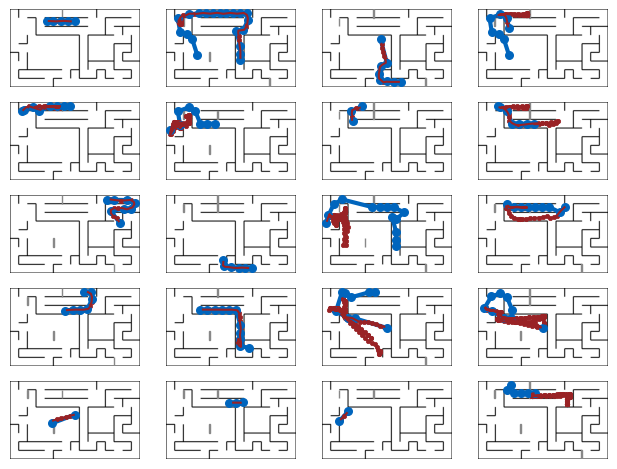

In [59]:
from system.plotting.plotHelper import TUM_colors

with open('../logs/topological_nav.log.d/multi_experiment+nn.log') as file:
    all_lines = file.readlines()

version = 5
summarize = True

paths = [line for line in all_lines if line.startswith('Path:')]
paths = [line.removeprefix('Path: ').strip().split(',') for line in paths]
paths = [list(map(int, path)) for path in paths]

cmdline = all_lines[0]
cmdline = cmdline.removeprefix('# nice python system/controller/topological/topological_navigation.py').strip().split(' ')
layout, base_map_filename, *flags = cmdline

#def get_map_evolution(base_map_filename, log_file, env_model, env_variant=None, summarize=True, version=5, **kwargs):
cogmap = LifelongCognitiveMap(load_data_from=base_map_filename, reachability_estimator=None, debug=False)

vector_nav_tracker = PathTracker()
topo_nav_tracker = TopologicalPathTracker(vector_nav_tracker, version=version)

fig, axes = plt.subplots(5, 4)
axes = axes.flatten()
axes_and_path = iter(zip(axes, paths, range(20)))

last_segment_shown = 0
def show_map(i, cogmap, *, line):
    global last_segment_shown, env_variant
    if line.startswith('Fail :(') or line.startswith('Success!'):
        pass
    elif line.startswith('[environment] Switching: env_variant='):
        env_variant = line.removeprefix('[environment] Switching: env_variant=')
        return
    else:
        return

    ax, planned_path, i = next(axes_and_path)

    #compute_metrics(len(stats['unobstructed_lines']), cogmap, env_model, stats)
    topological_path = [segment.nodes for segment in topo_nav_tracker.segments[last_segment_shown:]]
    vector_path = vector_nav_tracker.robot_positions[
        topo_nav_tracker.segments[last_segment_shown].steps.start
        :topo_nav_tracker.segments[-1].steps.stop
    ]
    last_segment_shown = len(topo_nav_tracker.segments)

    add_environment(ax, env_model, variant=env_variant)
    pcs = list(cogmap.node_network.nodes)
    pos = nx.get_node_attributes(cogmap.node_network, 'pos')
    planned_path = [pcs[i] for i in planned_path]
    plotPath(ax, cogmap, planned_path, node_size=30, color=TUM_colors['TUMBlue'])
    plotTrajectory(ax, vector_path)

    vector_nav_tracker.reset()
    topo_nav_tracker.reset()
    last_segment_shown = 0

cogmap.retrace_logs(
    map(lambda line: line.strip(), all_lines),
    callbacks=[
        vector_nav_tracker,
        show_map,
        topo_nav_tracker,
        ProgressBar(len(all_lines)),
    ],
    recreate_pcs=False,
)

fig.tight_layout()
fig.savefig('../../report/figures/final_multi_experiment.png')
plt.show()

In [38]:
help(plotPath)

Help on function plotPath in module system.plotting.plotResults:

plotPath(ax, cognitive_map, path: list['PlaceCell'] | list[int], color='#E3722280')



32580


# nice python system/tests/system_benchmark/long_unknown_nav.py final_layout final_layout.after_exploration.gpickle 0,61 --env-variant walls --log --re-type neural_network(reachability_network-boolor+lidar--raw_lidar+conv.25) --compass analytical -m inf


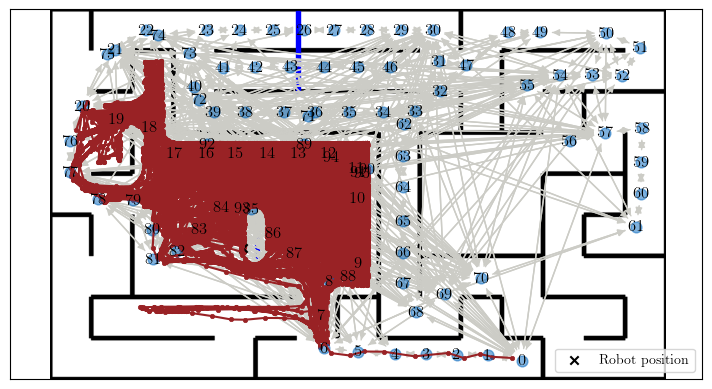

245


# nice python system/tests/system_benchmark/long_unknown_nav.py final_layout final_layout.after_exploration.gpickle 0,61 --log --re-type 'neural_network(reachability_network-boolor+lidar--raw_lidar+conv.25)'


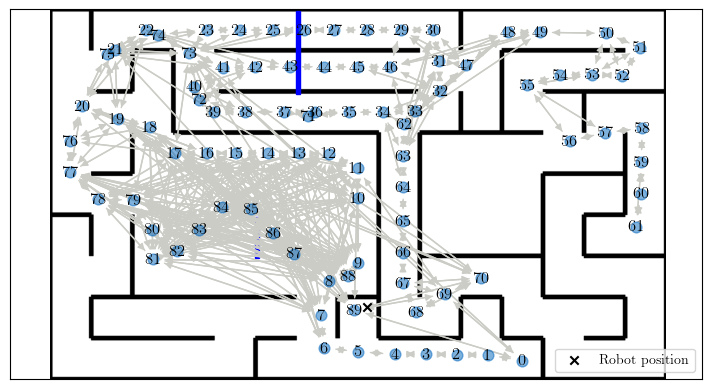

296


# nice python system/tests/system_benchmark/long_unknown_nav.py final_layout final_layout.after_exploration.gpickle 0,61 --env-variant walls --log --compass analytical --re-type view_overlap --pc-creation-re spikings --tactile-cone 210 --ray-length 2


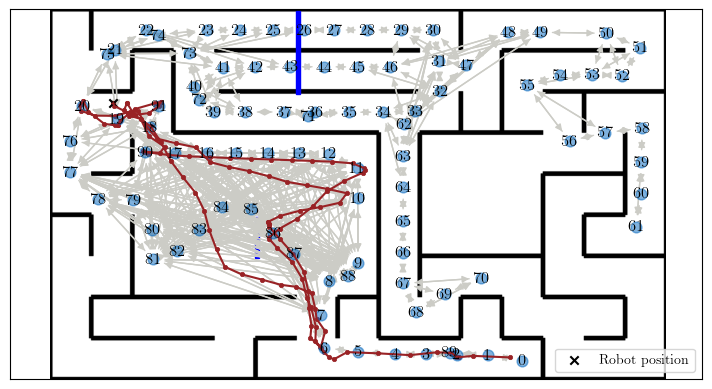

403


nice python system/tests/system_benchmark/long_unknown_nav.py final_layout final_layout.after_exploration+handcrafted.gpickle 0,61 --log --re-type neural_network(reachability_network-boolor-3colors+lidar--ego_bc+fc.25) --wall-colors 3colors


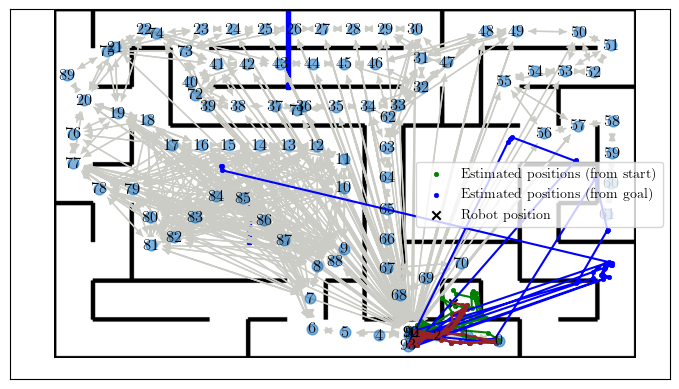

198


nice python system/tests/system_benchmark/long_unknown_nav.py final_layout final_layout.after_exploration.gpickle 0,61 --log --re-type view_overlap --pc-creation-re spikings


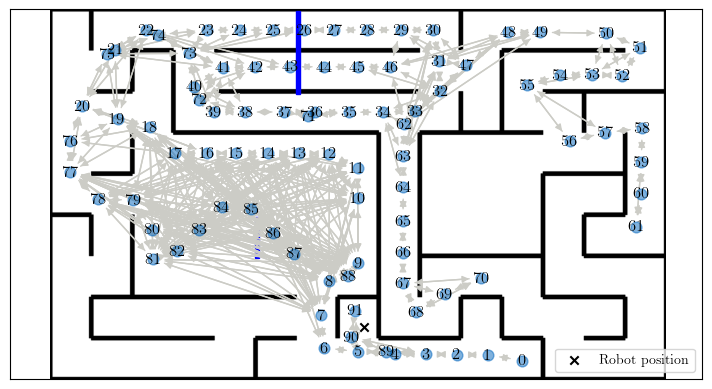

941


nice python system/tests/system_benchmark/long_unknown_nav.py final_layout final_layout.after_exploration.gpickle 0,61 --log --re-type view_overlap --pc-creation-re spikings -m inf


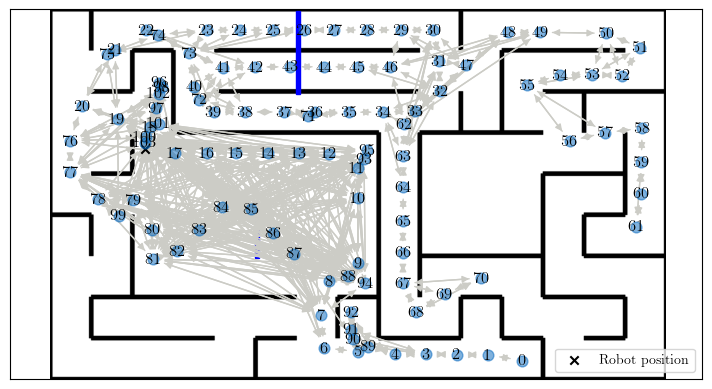

219


# nice python system/tests/system_benchmark/long_unknown_nav.py final_layout final_layout.after_exploration.gpickle 0,61 --log --re-type neural_network(reachability_network-boolor+lidar--raw_lidar+conv.25)


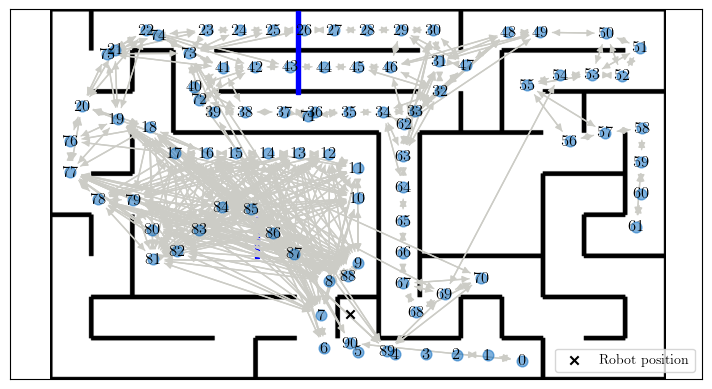

254


nice python system/tests/system_benchmark/long_unknown_nav.py final_layout final_layout.after_exploration.gpickle 0,61 --log --re-type view_overlap


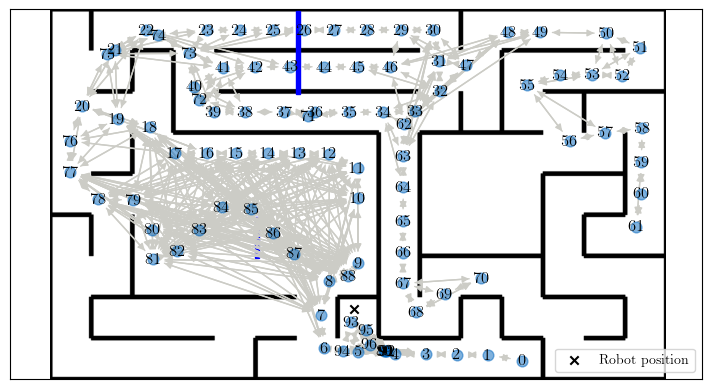

11547


# nice python system/tests/system_benchmark/long_unknown_nav.py final_layout final_layout.after_exploration.gpickle 0,61 --env-variant walls --log --re-type view_overlap --pc-creation-re spikings --compass analytical -m inf


NameError: name 'Error' is not defined

In [48]:
from glob import glob
for filename in glob('../logs/topological_nav.log.d/final_experiment*'):
    try:
        with open(filename) as file:
            first_line = next(file)
        first_line = first_line.removeprefix('#')
        first_line = first_line.strip()
        first_line = first_line.removeprefix('nice ')
        tokens = first_line.split(' ')
        assert tokens[0] == 'python', tokens
        assert tokens[1] == 'system/tests/system_benchmark/long_unknown_nav.py'
        env_model, cogmap, endpoints = tokens[2:5]
        assert env_model == 'final_layout'
        assert endpoints == '0,61'
        get_map_evolution(
            cogmap, filename,
            env_model, env_variant='walls', accept_incomplete_last_line=True
        )
    except Error as e:
        print('Error:', e)

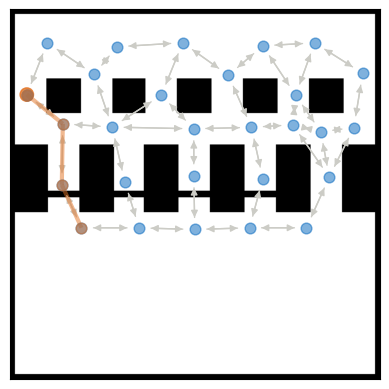

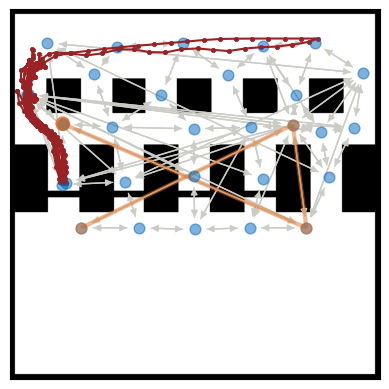

In [33]:
with open('../logs/topological_nav.log.d/lifelong_learning+nn--boolor.3.log') as f:
    all_lines = f.readlines()

cogmap = LifelongCognitiveMap(load_data_from='linear_sunburst.handcrafted.gpickle', reachability_estimator=None, debug=False)

path = [17,23,18,2]
pcs = list(cogmap.node_network.nodes)
path_pcs=[pcs[i] for i in path]
plotTrajectoryInEnvironment(
    env_model='linear_sunburst', env_variant='plane_walls', cognitive_map=cogmap,
    path=path_pcs, start=path_pcs[0].pos,
    trajectory=False, #xy_coordinates=self.robot_positions,
    show=False,
)
plt.savefig('/tmp/before_navigation.png')

robot_positions = []
cogmap.retrace_logs(
    map(lambda line: line.strip(), all_lines),
    robot_positions=robot_positions,
)

path=[23,4,24,2]
pcs = list(cogmap.node_network.nodes)
path_pcs=[pcs[i] for i in path]
plotTrajectoryInEnvironment(
    env_model='linear_sunburst', env_variant='plane_walls', cognitive_map=cogmap,
    path=path_pcs, start=path_pcs[0].pos,
    trajectory=True, xy_coordinates=robot_positions,
    show=False,
)
plt.savefig('/tmp/after_navigation.png')

In [34]:
robot_positions[-1]

(0.71617555, 8.26545332)

In [35]:
#!cat '../logs/topological_nav.log.d/lifelong_learning+nn--boolor.3.log' | grep -i 'path'
!cat ../logs/topological_nav.log.d/lifelong_learning+nn--boolor.3.log | grep '^Robot position:' | wc -l

281


988


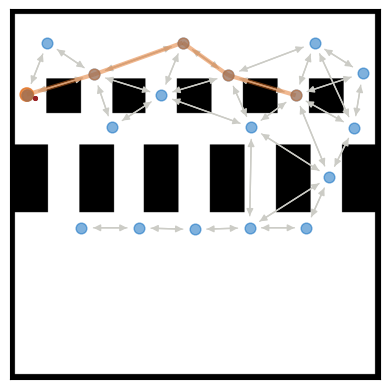

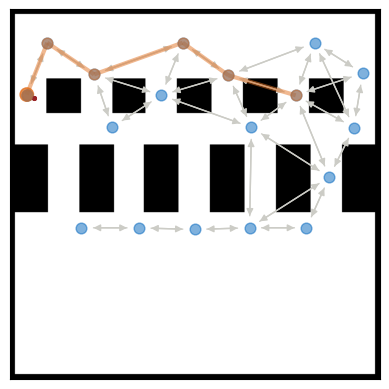

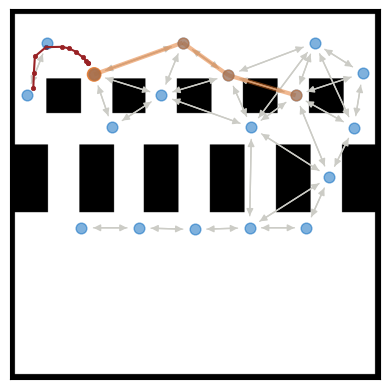

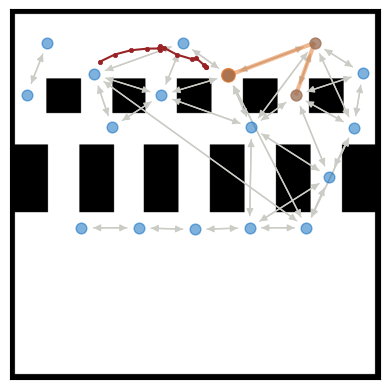

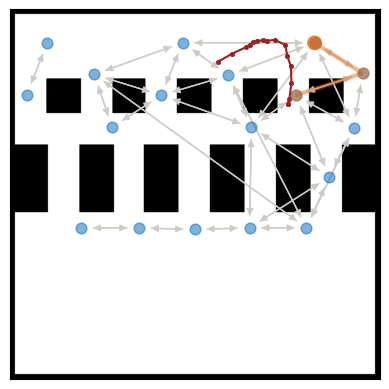

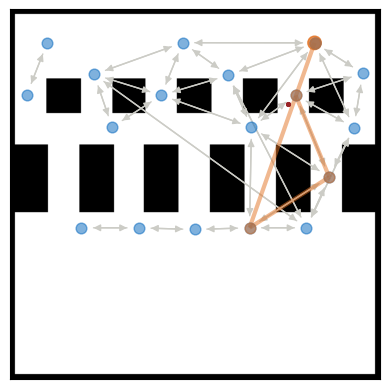

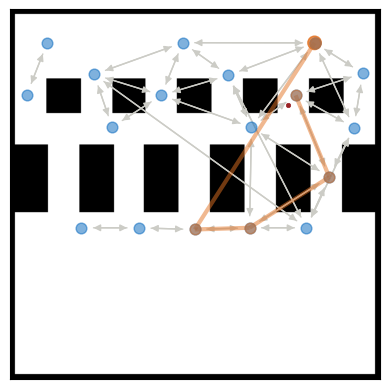

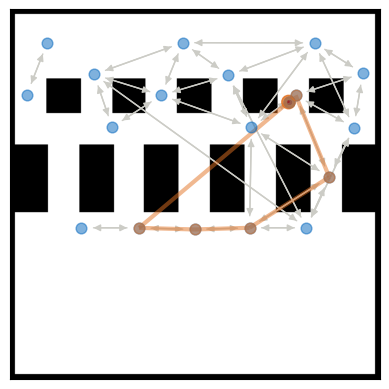

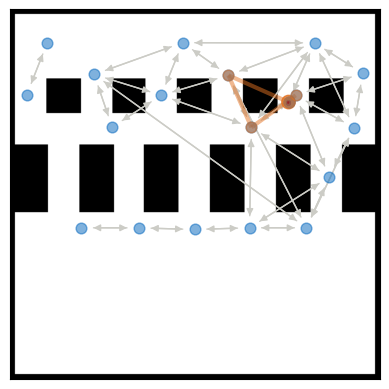

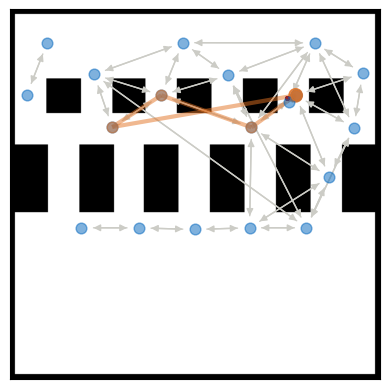

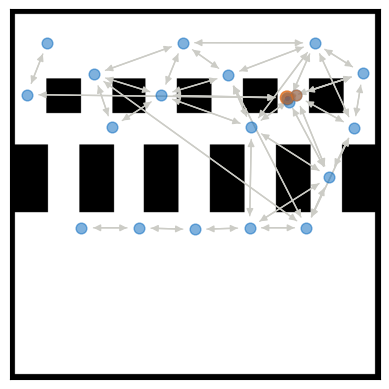

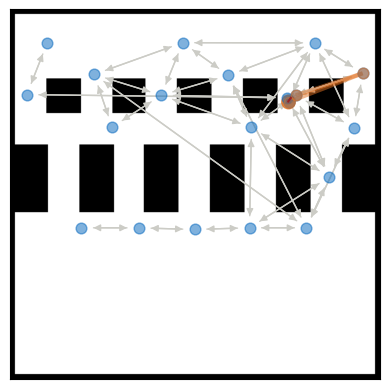

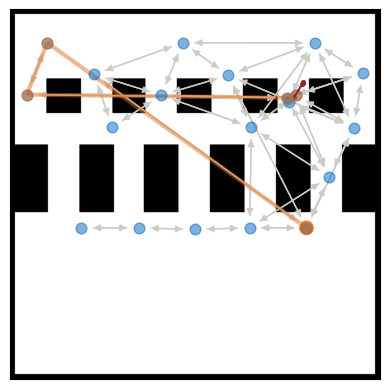

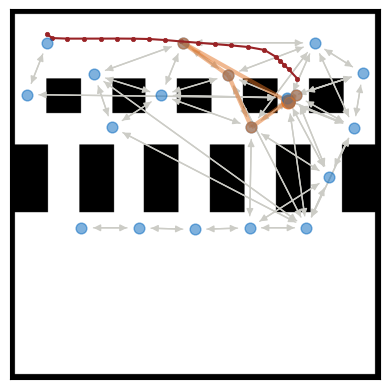

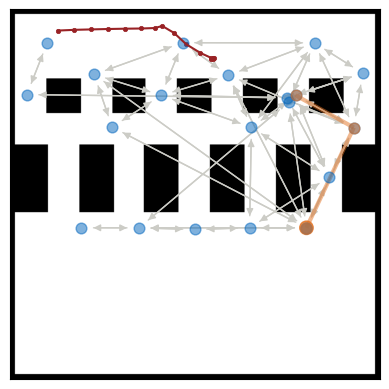

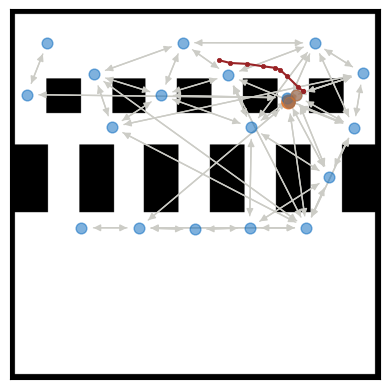

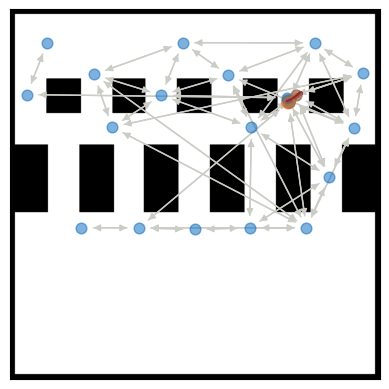

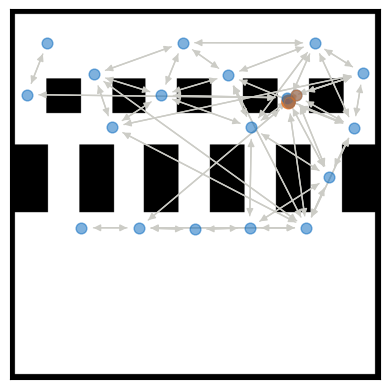

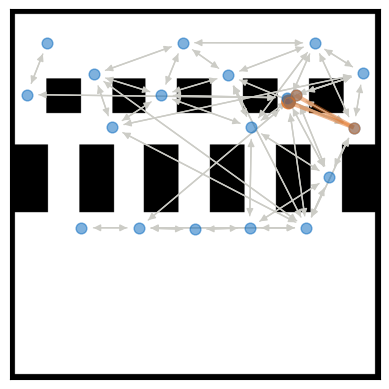

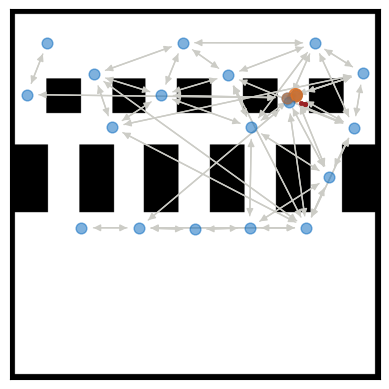

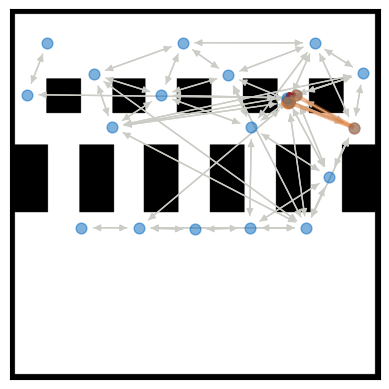

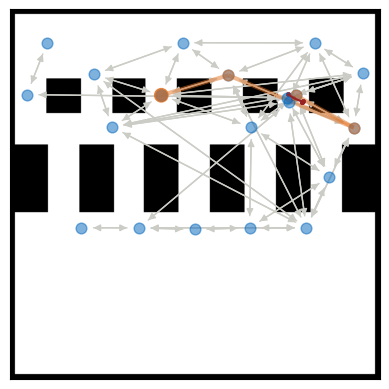

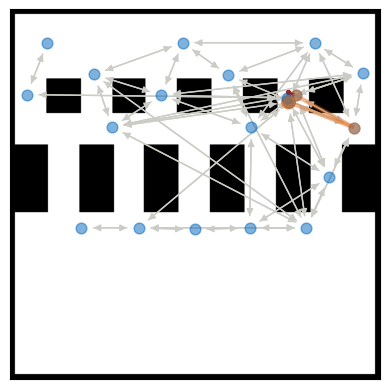

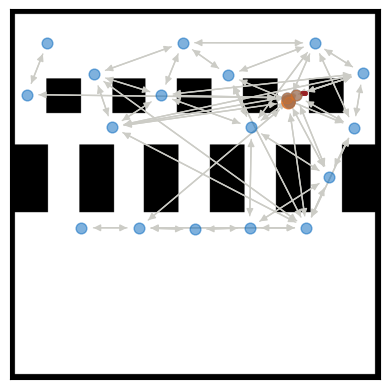

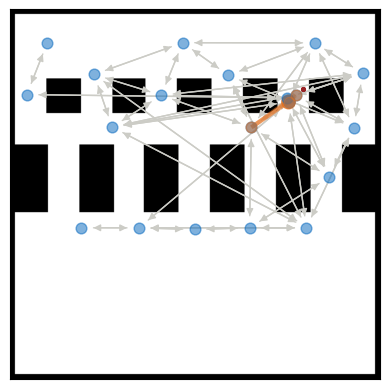

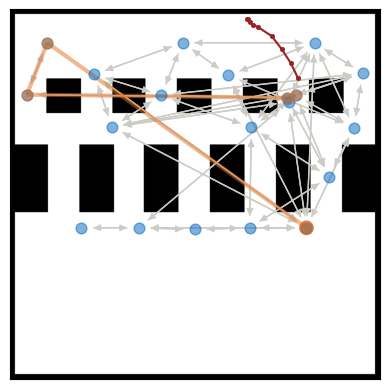

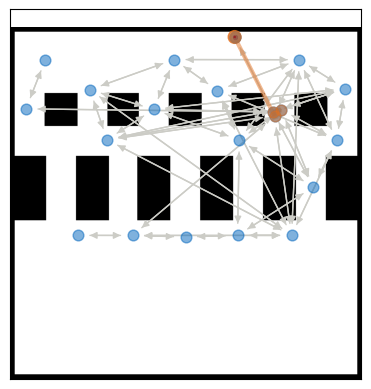

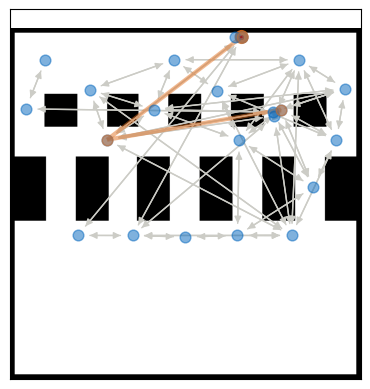

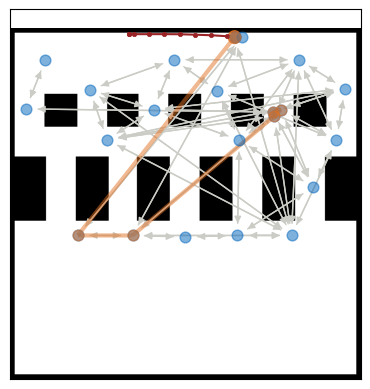

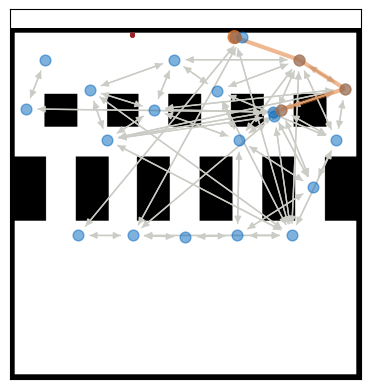

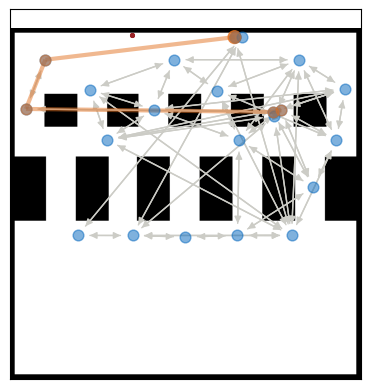

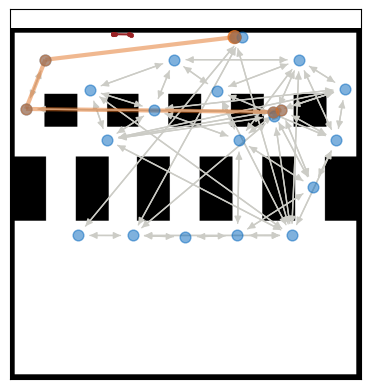

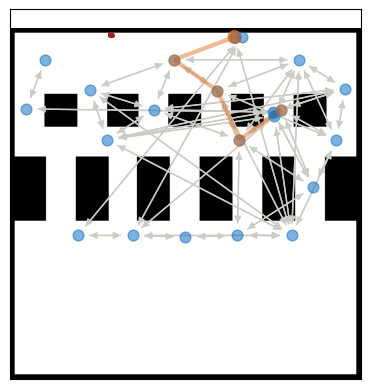

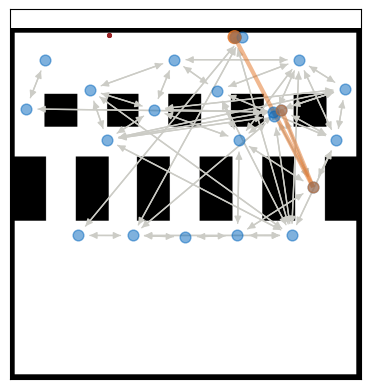

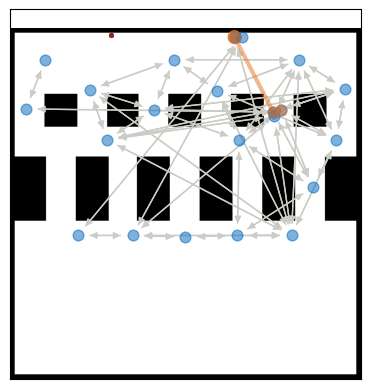

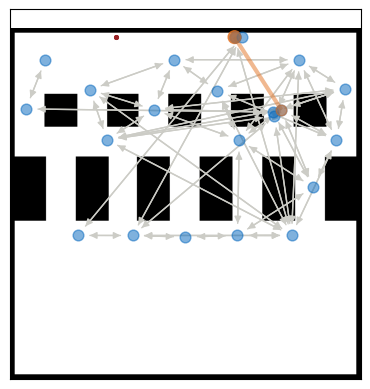

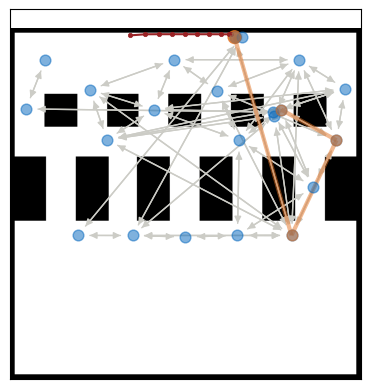

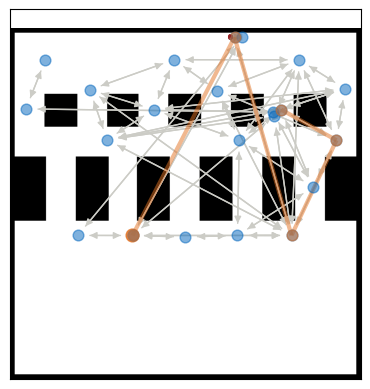

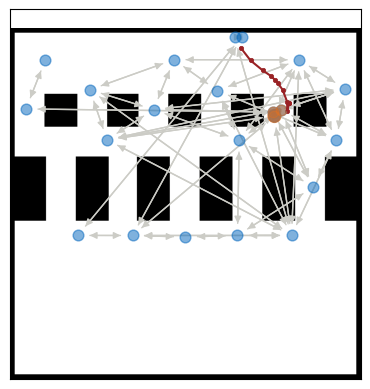

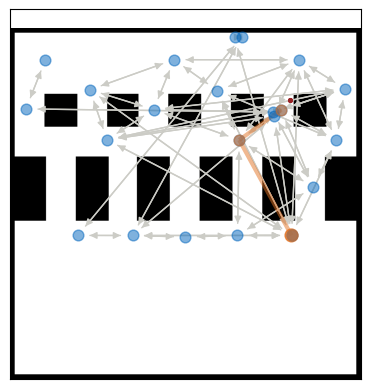

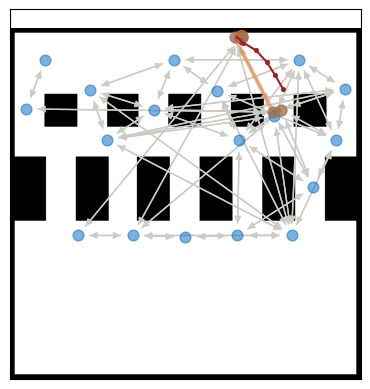

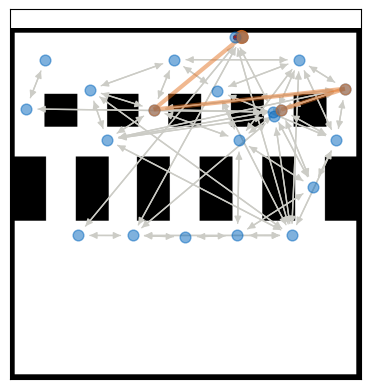

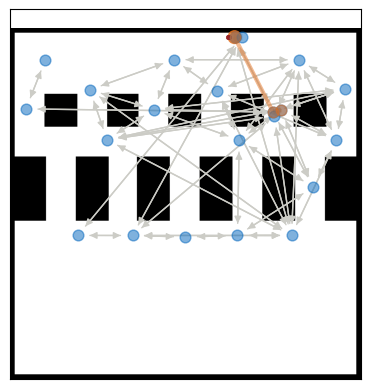

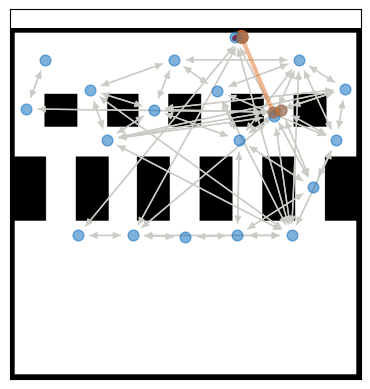

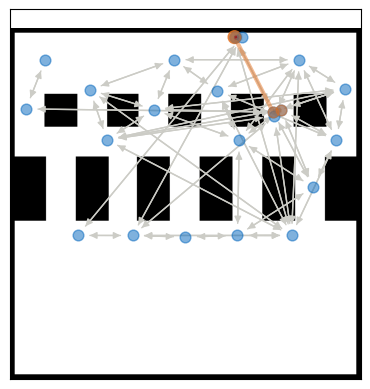

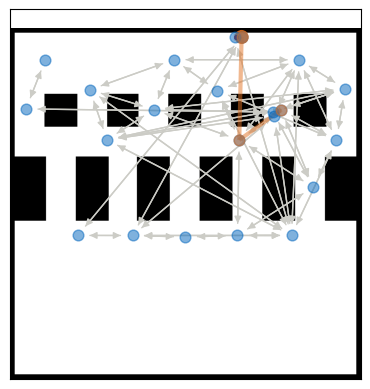

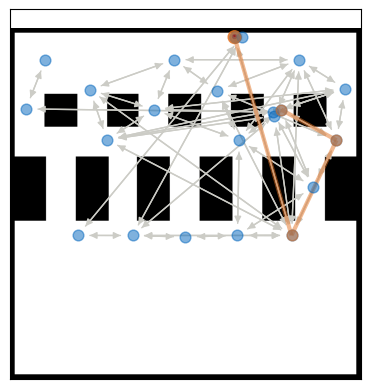

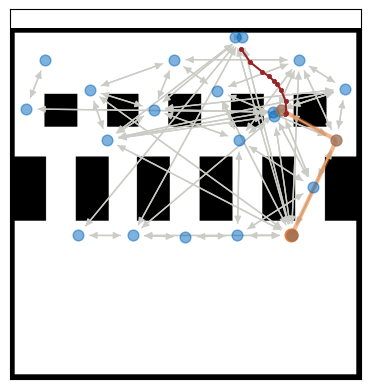

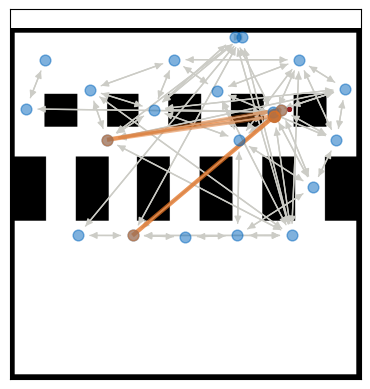

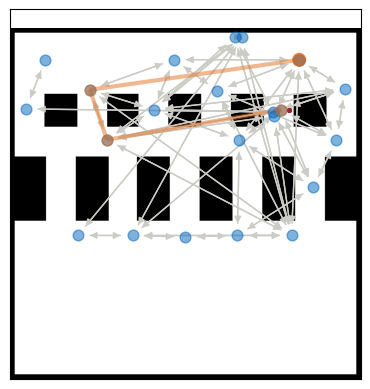

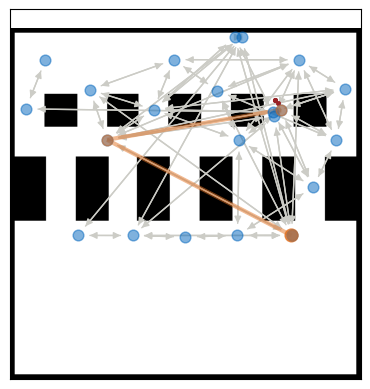

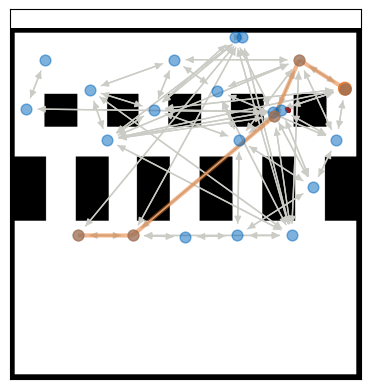

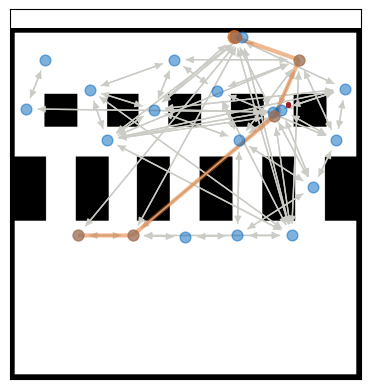

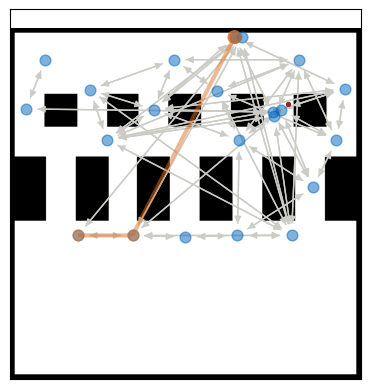

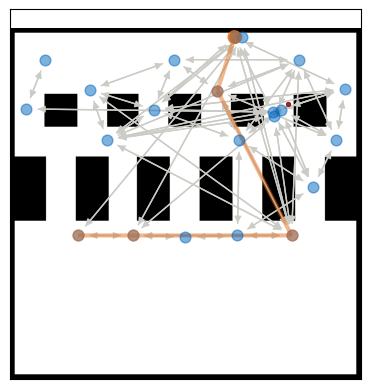

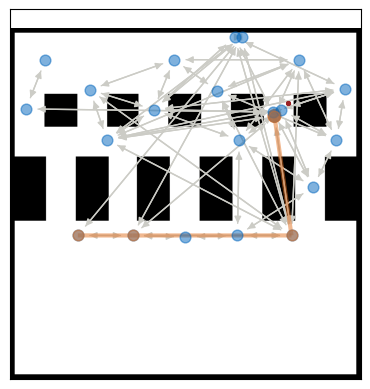

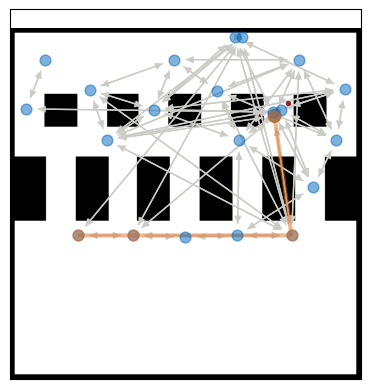

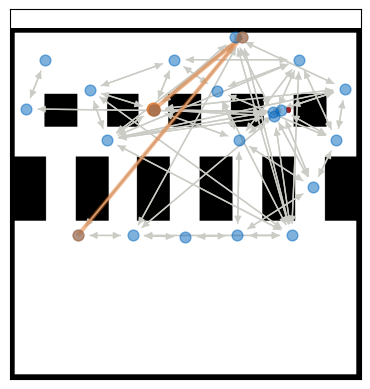

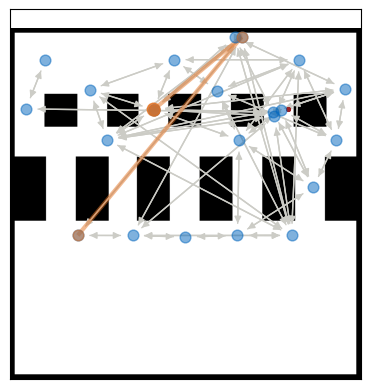

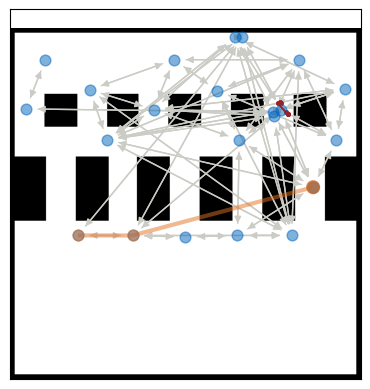

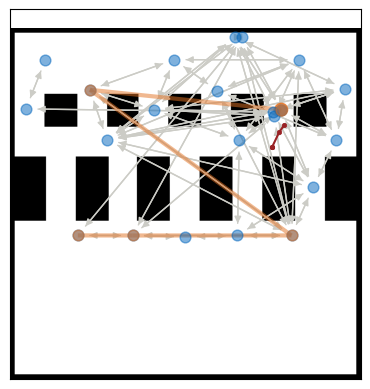

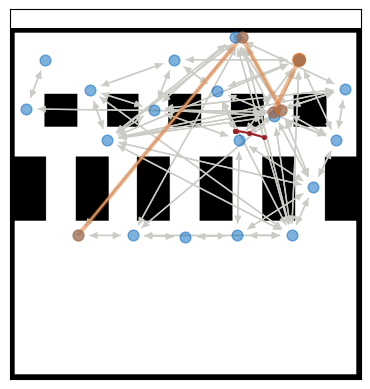

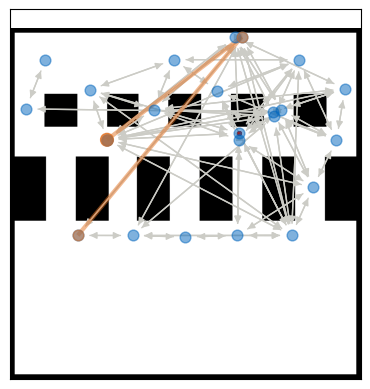

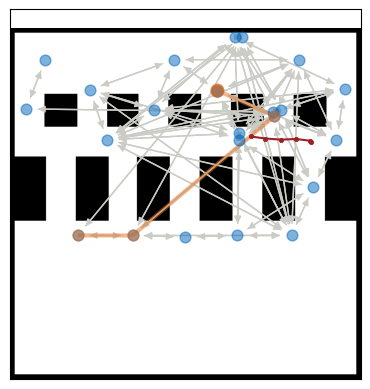

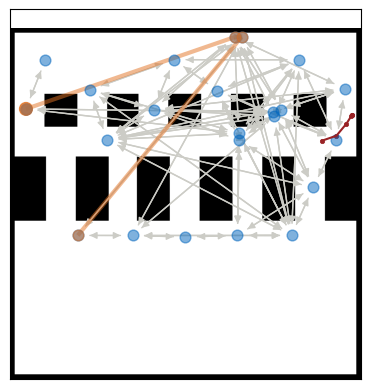

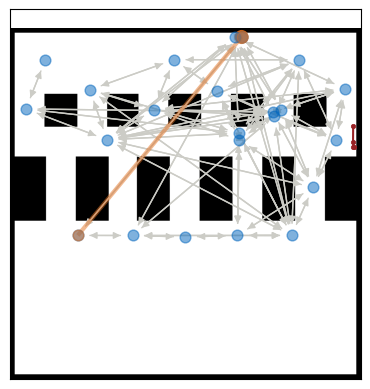

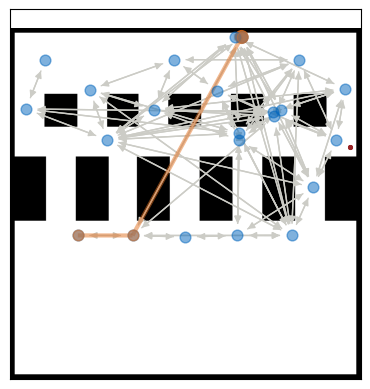

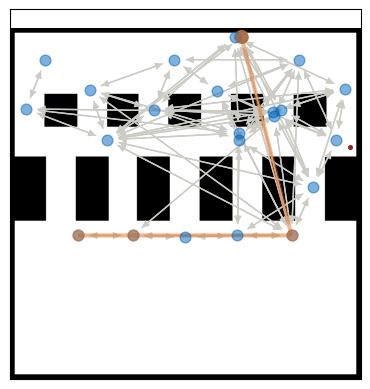

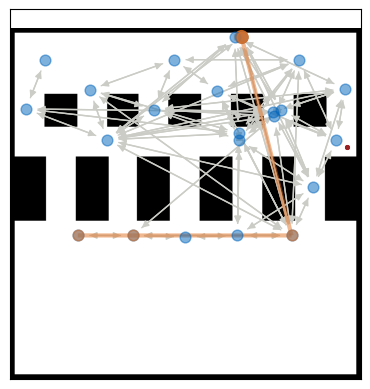

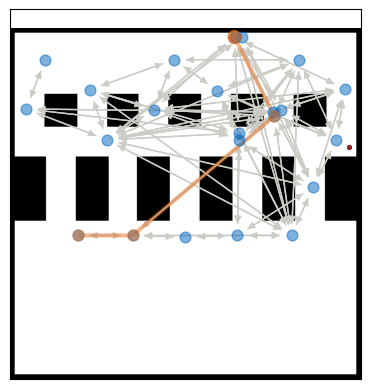

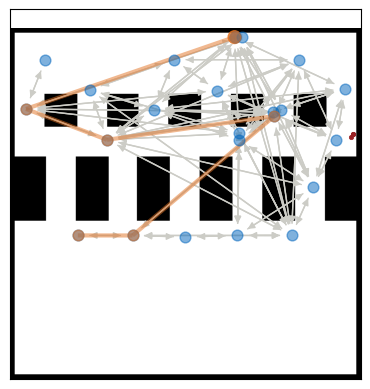

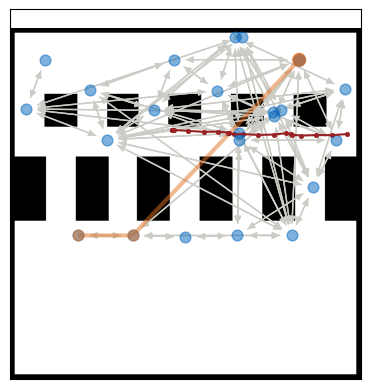

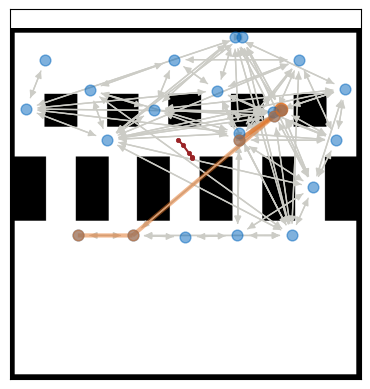

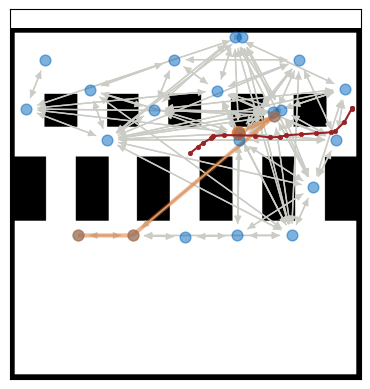

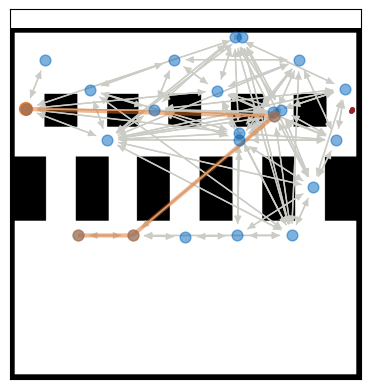

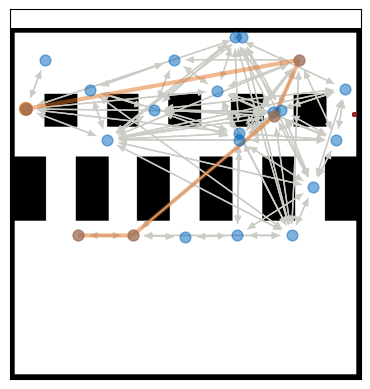

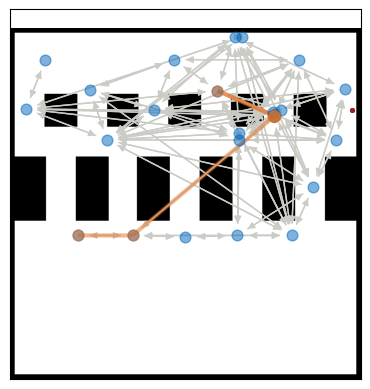

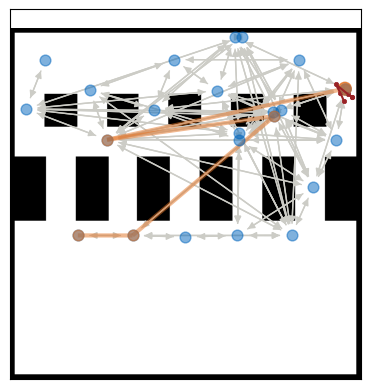

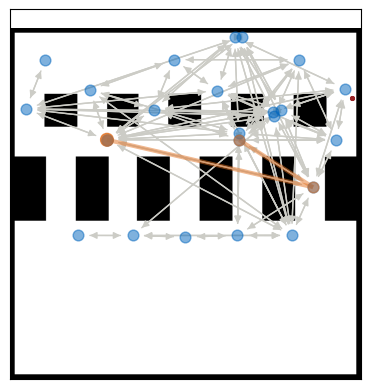

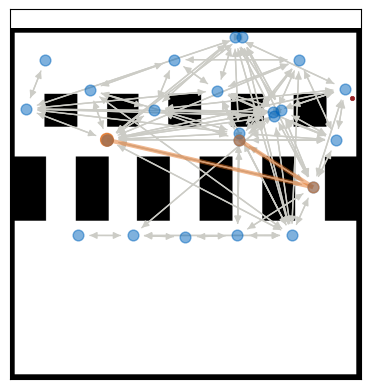

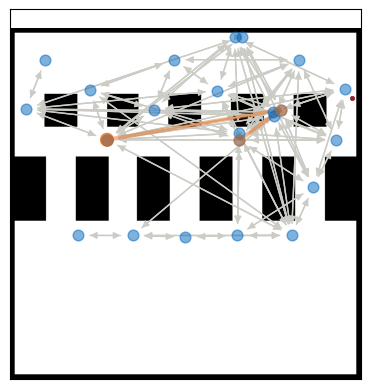

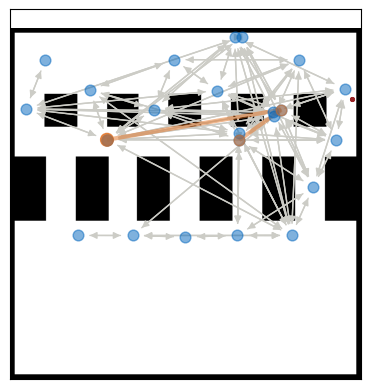

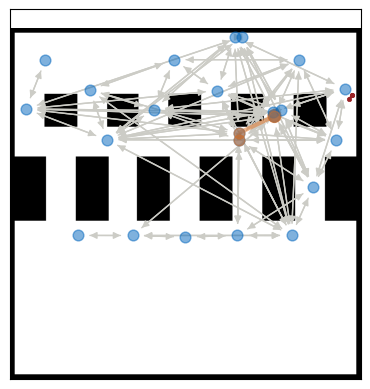

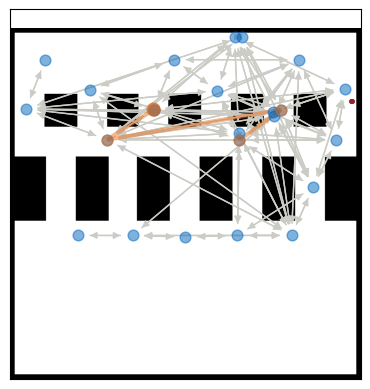

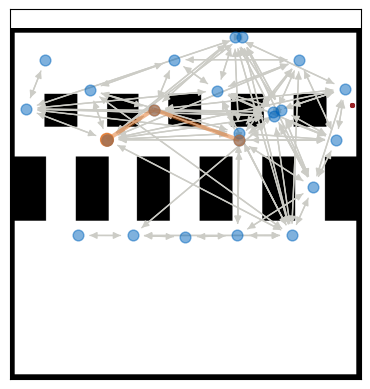

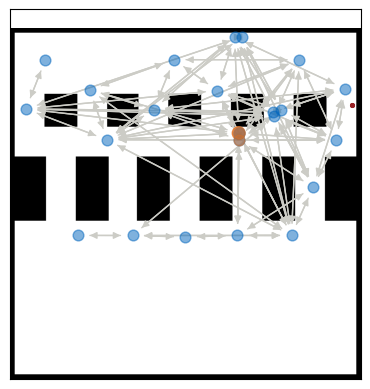

AssertionError: 

In [140]:
get_map_evolution('linear_sunburst.after_exploration.gpickle', '../logs/topological_nav.log.d/topological_nav+0.8thresh+nn--boolor.log', env_model, accept_incomplete_last_line=True)

1468


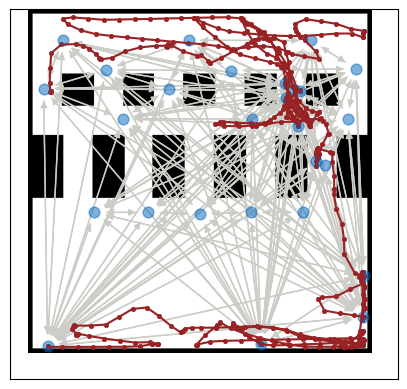

In [189]:
get_map_evolution('linear_sunburst.after_exploration.gpickle', '../logs/topological_nav.log.d/topological_nav+0.8thresh+spikings.2.log', env_model)

In [14]:
robot_positions = []
with open('../logs/topological_nav.log.d/topological_nav+0.8thresh+nn--boolor.log') as file:
    for line in file.readlines():
        if line.startswith('Robot position'):
            try:
                line = line.removeprefix('Robot position: ')
                line = line.strip()
                assert line[0] == '[' and line[-1] == ']'; line = line[1:-1]
                line = line.strip()
                x, *_optional_space, y = line.split(' ')
                x, y = float(x), float(y)
                robot_positions.append((x, y))
            except:
                print(repr(line))
                raise

In [15]:
!cat '../logs/topological_nav.log.d/topological_nav+0.8thresh+nn--boolor.log' | head

# nice python -m pdb -c c system/tests/system_benchmark/long_unknown_nav.py linear_sunburst linear_sunburst.handcrafted.gpickle 17,2 --env-variant plane_doors --log --re-type 'neural_network(reachability_network-boolor+lidar--raw_lidar+conv.25)' -m inf --dump-all-steps logs/long_nav+nn--boolor
Path: 17,23,18,2
edge [17-23]: success True conn 0.8644801980198019
Vector navigation: goal=23, success=True
Updating self.prior_idx_pc_firing=28
edge [23-18]: success True conn 0.95
Vector navigation: goal=18, success=True
Updating self.prior_idx_pc_firing=17
Robot position: [0.60510593 8.14605851]
Robot position: [0.68901523 7.86354228]


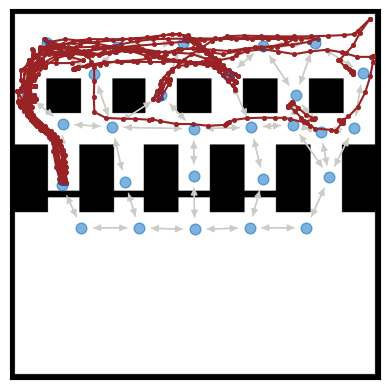

In [16]:
env_model = 'linear_sunburst'
cogmap = LifelongCognitiveMap(load_data_from='linear_sunburst.handcrafted.gpickle', reachability_estimator=None, debug=False)
fig, ax = plt.subplots()
add_environment(ax, env_model, variant='plane_walls')
plotCognitiveMap(ax, cogmap)
plotTrajectory(ax, robot_positions)
#fig.savefig('/tmp/figure.png')

In [ ]:
previously_visited = [17,23,23,18,18,23,18,23,17,23,18,23,23,17,18,23,18,23,17,23,23]
still_remaining=[23,4,24,2]
path = previously_visited + still_remaining
#xy_coordinates=[(0.60510593, 8.14605851), (0.68901523, 7.86354228), (1.04190566, 7.5355647), (1.21478023, 7.38164583), (1.31797521, 7.27721998), (1.39887888, 7.19238266), (1.49429268, 7.06918591), (1.64113628, 6.66451589), (1.66838678, 6.17040107), (1.66514979, 5.82815066), (1.66510656, 5.82824009)]
cogmap = LifelongCognitiveMap(load_data_from='linear_sunburst.handcrafted.gpickle', reachability_estimator=None, debug=False)
pcs = list(cogmap.node_network.nodes)
path_pcs=[pcs[i] for i in path]

plotTrajectoryInEnvironment(
    env_model='linear_sunburst', env_variant='plane_walls', cognitive_map=cogmap,
    path=path_pcs, start=path_pcs[0].pos,
    trajectory=False, #xy_coordinates=self.robot_positions,
    show=False,
)
plt.savefig('/tmp/final_experiment.png')